<h1 style="text-align: center;"><u><b>CSC3066 Deep Learning (Fake News Detection)</u></b></h1>

<h5 style="margin: 0; padding:0; text-align: right;"><b>Student Name:</b> Ryan McKee</h5>
<h5 style="margin: 0; padding:0; text-align: right;"><b>Student Number:</b> 40294886</h5>
<h5 style="margin: 0; padding:0; text-align: right;"><b>Date:</b> 02/04/2024</h5>

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Introduction</u></h3>

<h5 style="margin: 0; padding: 0; text-align: left;">
This notebook presents the implementation of four distinct approaches for text veracity classification using neural networks. Supervised neural networks will be trained on the provided train.csv, comprising 2000 labeled tweets, and evaluated using test.csv, which contains 500 labeled tweets. The document will explore various methods to enhance model performance, including preprocessing techniques for both training and test data, as well as model architecture and hyperparameter tuning. The best-performing version of the model will be presented after extensive experimentation with these techniques.


The analyzed model types include:

- <b>Multi-Layer Perceptron (MLP)</b>: Utilizes the training set, with each training data record represented as a single vector derived from a pre-trained word embeddings vector.
- <b>Multi-Layer Perceptron (MLP) with Keras Embedding Layer:</b> Utilizes the Keras Embedding layer to embed the training data in a pre-trained embedding model.
- <b>Convolutional Neural Network (CNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.
- <b>Recurrent Neural Network (RNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, also using the Keras Embedding layer.
</h5>

<h3 style="margin: 0; padding: 0; text-align: left;"><u>Imports</u></h3>
<h5 style="margin: 0.5; padding: 0; text-align: left;">In this section, the imports for the two models are showcased. The MLP models will utilize NumPy for matrix calculations, Pandas for importing datasets, and TensorFlow Keras for data preprocessing leading to the creation of artificial neural networks. Additionally, the KeyedVectors function is imported for [purpose], the re module for text manipulation, and nltk for pre-processing tasks such as removing stop words.</h5>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import he_uniform
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time

tf.config.set_visible_devices([], 'GPU') # Disable GPU: Issues currently with GPU memory growth

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Data Loading</u></h3>
<h5 style="margin: 0; padding: 0; text-align: left;">
In this section, data loading is executed. Utilizing the pandas library, the training data (consisting of 2000 text tweets), testing data (comprising 500 text tweets), and their corresponding labels are loaded as NumPy arrays. Subsequently, pre-trained word embeddings vector representations for words are imported. These embeddings will serve to embed the words in our training and testing datasets, enabling the passage of words in our sentences into our four distinct models.
</h5>

In [2]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv')
X_train = df_training.values[:, 0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:, 0])
y_test = np.array(df_testing.values[:, 1], dtype=np.float32)

# Load the GLoVe word embeddings
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Pre-processing: Cleaning the Data</u></h3>
<h5 style="margin: 0; padding: 0; text-align: left;">
In this section, I implement various pre-processing steps to cleanse both the training and testing data, removing noise that could impede the model's learning process.

These steps comprise:

- Removing Special Characters/Words (Punctuation/URLs): Eliminating special characters and words such as punctuation and URLs.
- Removing Stopwords: Eliminating any words contained within the sentences that are listed in the nltk.stopwords repository.
- Performing Lemmatization: Transforming words into their root forms to facilitate improved text analysis.
</h5>

In [3]:
def preprocess_text(text):
    # Lower case the text
    text = text.lower()
    # # Remove special characters
    # text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply pre-processing to the training and testing data
X_train = [preprocess_text(sentence) for sentence in X_train]
X_test = [preprocess_text(sentence) for sentence in X_test]

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Pre-processing: Machine Learning Tokenization and Padding</u></h3>
<h5 style="margin: 0; padding: 0; text-align: left;">
During this phase, I will conduct tokenization using Keras for the training data, followed by padding the sentences. This ensures uniformity in the number of words per sentence, aligning with the requirement of maintaining consistent neuron inputs for the MLP.
</h5>

In [4]:
# Fit tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Tokenise the training data and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the training and test data sentences to the same length
max_len = max([len(x) for x in X_train]) 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Model Analysis Utility Functions</u>
<h5 style="margin: 0; padding: 0; text-align: left;">
Below are the utility functions that will be used for each of the differen models for analysis of those models
</h5>

In [11]:
# function will evaluate a model passed in params
def evaluate_model(model, X, y):
    loss, accuracy = model.evaluate(X, y)
    return loss, accuracy

# Function that will take a model as input, and train it using 10-Fold Cross Validation
def train_model_with_kfold(model, X, y, n_folds, batch_size, epochs, verbose=0):
    kf = KFold(n_splits=n_folds, shuffle=True)
    total_training_time = 0 
    training_accuracies, validation_accuracies = [], []
    training_losses, validation_losses = [], []

    flat_X = X.reshape(X.shape[0], -1)

    for fold_idx, (train_index, val_index) in enumerate(kf.split(flat_X)):
        print(f"Fold {fold_idx + 1}/{n_folds}")
        X_train_fold, X_val_fold = flat_X[train_index], flat_X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Evaluating the model before training
        initial_training_loss, initial_training_accuracy = evaluate_model(model, X_train_fold, y_train_fold)
        initial_validation_loss, initial_validation_accuracy = evaluate_model(model, X_val_fold, y_val_fold)
        
        start_time = time.time()
        # Fit the model on the training data
        history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold), verbose=verbose)
        end_time = time.time()
        total_training_time += end_time - start_time
        
        # Get the final training and validation accuracy
        training_accuracies.append((initial_training_accuracy, *history.history['accuracy']))
        validation_accuracies.append((initial_validation_accuracy, *history.history['val_accuracy']))
        
        # Get the final training and validation loss
        training_losses.append((initial_training_loss, *history.history['loss']))
        validation_losses.append((initial_validation_loss, *history.history['val_loss']))

        print(f"Fold {fold_idx + 1}/{n_folds} - Training Accuracies: {training_accuracies[-1]}, Validation Accuracies: {validation_accuracies[-1]}")

    average_training_time = total_training_time / n_folds
    return model, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time

In [6]:
def plot_learning_curves(plot_title_loss, plot_title_accuracy, train_loss, val_loss, train_acc, val_acc, average_training_time):
    plt.figure(figsize=(14, 6))  # Wider plot
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(plot_title_loss)
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(plot_title_accuracy)
    plt.legend()

    # Display average training time
    plt.figtext(0.5, 0.02, f'Average Training Time: {average_training_time:.2f} seconds', ha='center')

    plt.tight_layout()
    plt.show()

In [7]:
def evaluate_predictions(predictions, actual_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(actual_labels, predictions.round())
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(actual_labels, predictions.round())
    precision = precision_score(actual_labels, predictions.round())
    recall = recall_score(actual_labels, predictions.round())
    f1 = f1_score(actual_labels, predictions.round())

    # Plot the confusion matrix along with metrics
    plt.figure(figsize=(14, 8))  # Wider plot

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix\nAccuracy:{:.2f} | Precision:{:.2f} | Recall:{:.2f} | F1 Score:{:.2f}".format(accuracy, precision, recall, f1))
    
    # Plot metrics
    plt.subplot(1, 2, 2)
    sns.barplot(x=["Accuracy", "Precision", "Recall", "F1 Score"], y=[accuracy, precision, recall, f1])
    plt.ylim(0, 1)
    plt.title("Evaluation Metrics")
    plt.tight_layout()
    
    plt.show()


In [8]:
def convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses):
    # Convert lists to NumPy arrays
    training_accuracies = np.array(training_accuracies)
    training_losses = np.array(training_losses)
    validation_accuracies = np.array(validation_accuracies)
    validation_losses = np.array(validation_losses)

    return training_accuracies, training_losses, validation_accuracies, validation_losses

<h2 style="margin: 0.5; padding: 0; text-align: left;"><center><b><u>MLP with flattened glove embedded word vector's</u></b></center></h2>

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Manually Embedding Tokenized Training and Testing Data</u></h3>
<h5>
In this version of the model, I am required to manually embed each tokenized word from both the training and testing datasets. Below is the code that accomplishes this task. I have created an embed_text_glove function that iterates through the tokens within a sequence provided as function parameters. It then locates the corresponding word value from the word_index, also passed as a parameter, and retrieves the embedding for each individual token from the token sequence. These embeddings are then added to the embedded sentence object. Finally, the embedded sentence object is returned once each word has been iterated through.
</h5>

In [9]:
# Convert tokenized words to glove embeddings
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

# Embed the training and test data
X_train_glove_embedded = embed_text_glove(X_train, tokenizer.word_index)
X_test_glove_embedded = embed_text_glove(X_test, tokenizer.word_index)

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Train MLP With Flattened Glove Word Embedding vectors</u></h3>

In this flattened MLP phase I will be applying embedding each of the words within the X_train and X_test with their dimensions in the glove_embedding matrix.

Fold 1/10
7/7 [==============================] - 0s 6ms/step - loss: 0.7804 - accuracy: 0.4350
Epoch 1/20
57/57 [==============================] - 2s 17ms/step - loss: 0.7587 - accuracy: 0.5911 - val_loss: 0.7474 - val_accuracy: 0.6400
Epoch 2/20
57/57 [==============================] - 1s 15ms/step - loss: 0.7313 - accuracy: 0.7261 - val_loss: 0.7267 - val_accuracy: 0.6800
Epoch 3/20
57/57 [==============================] - 1s 14ms/step - loss: 0.7088 - accuracy: 0.7767 - val_loss: 0.7088 - val_accuracy: 0.7150
Epoch 4/20
57/57 [==============================] - 1s 14ms/step - loss: 0.6885 - accuracy: 0.7917 - val_loss: 0.6934 - val_accuracy: 0.7200
Epoch 5/20
57/57 [==============================] - 1s 14ms/step - loss: 0.6703 - accuracy: 0.7983 - val_loss: 0.6800 - val_accuracy: 0.7000
Epoch 6/20
57/57 [==============================] - 1s 13ms/step - loss: 0.6546 - accuracy: 0.8122 - val_loss: 0.6686 - val_accuracy: 0.7050
Epoch 7/20
57/57 [==============================] - 1s 13ms

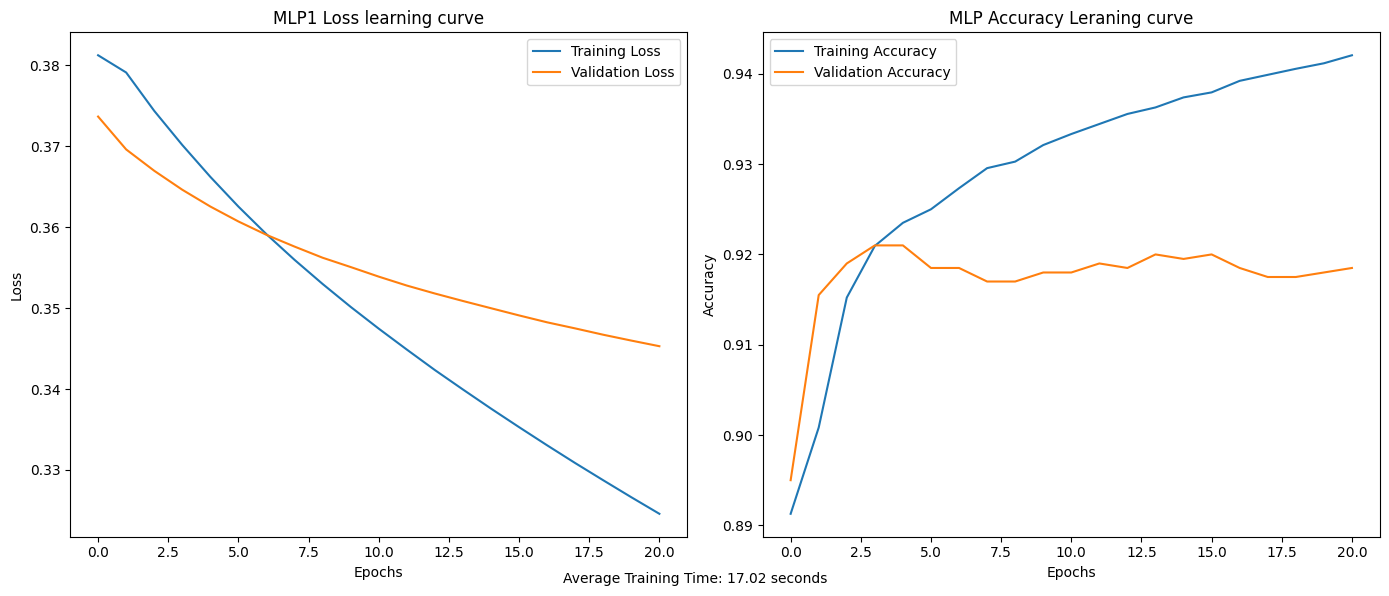

16/16 [==============================] - 0s 6ms/step


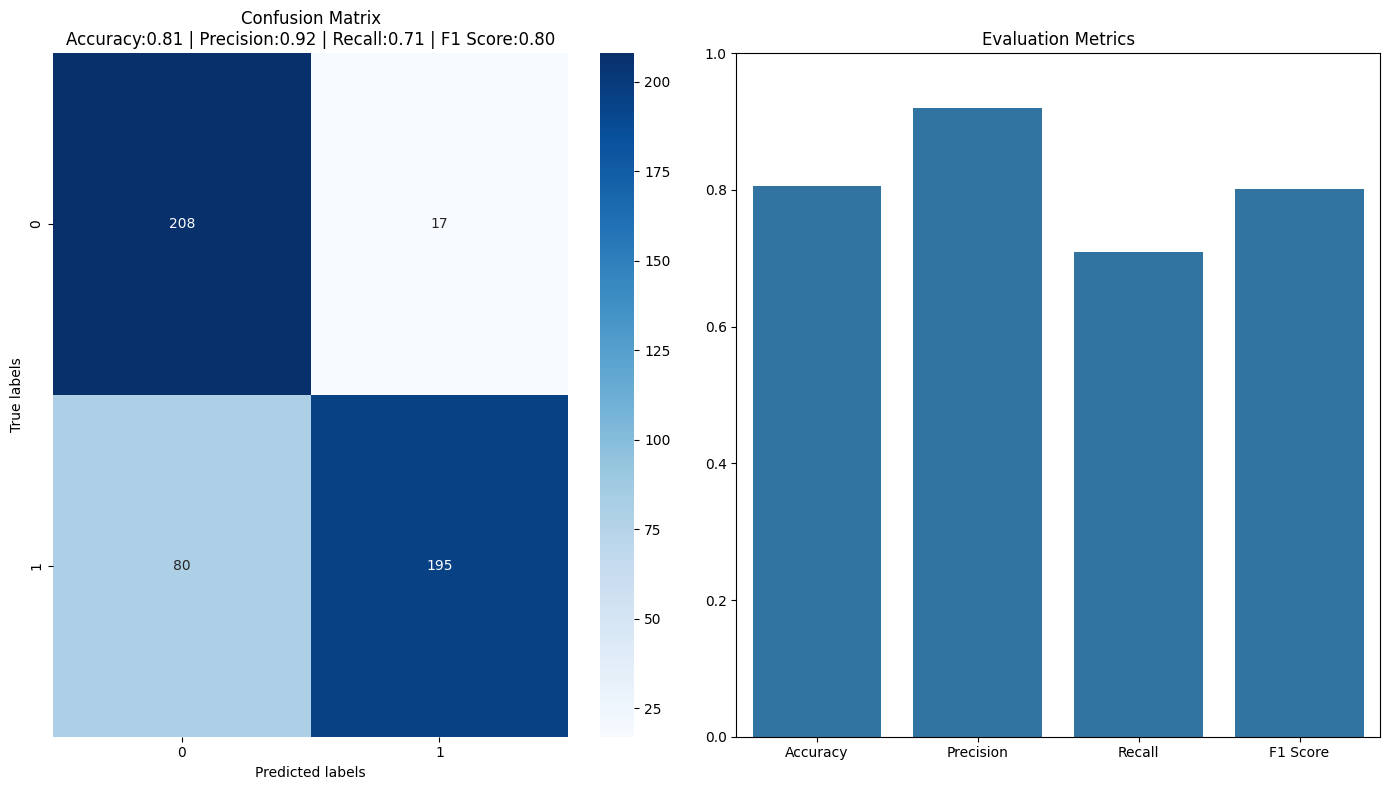

In [12]:
batch_size = 32
epochs = 20 
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 
n_folds = 10 
initializer = he_uniform(seed=42) 
regularizer = l2(0.01) 
activation = 'relu' 
loss = 'binary_crossentropy' 
hl1_size = 4 

# Create MLP1 using kfold
mlp1 = Sequential()
mlp1.add(Dense(hl1_size, activation=activation, input_shape=(max_len * 300,), kernel_regularizer=regularizer)) # hidden layer
mlp1.add(Dense(1, activation='sigmoid'))
mlp1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
mlp1, training_accuracies, training_losses, validation_accuracies, validation_losses, average_training_time  = train_model_with_kfold(mlp1, X_train_glove_embedded, y_train, n_folds, batch_size, epochs, verbose=1)
training_accuracies, training_losses, validation_accuracies, validation_losses = convert_to_arrays(training_accuracies, training_losses, validation_accuracies, validation_losses)

# Plot the learning curves
plot_learning_curves('MLP1 Loss learning curve', 'MLP Accuracy Leraning curve', training_losses.mean(axis=0), validation_losses.mean(axis=0), training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), average_training_time)

# Evaluate the model on the test data
flattened_X_test = np.reshape(X_test_glove_embedded, (X_test_glove_embedded.shape[0], -1))
MLP_predications = mlp1.predict(flattened_X_test)
evaluate_predictions(MLP_predications, y_test)

## MLP using keras embedding layer

<h3>Constructing the embedding matrix for the Embedding layer of the MLP<h3>

In this phase I will construct the embedding matrix for the embedding layer of the MLP this layer will convert a tokenized training set and testing set and convert it to it's glove embeddings then flatten it for input into the MLP

In [6]:
# Construct the model weight matrix for embedding layer
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove.key_to_index:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

<h2>Hyper-parameter settings for MLP using keras embedding layer<h2>

In [206]:
from keras.regularizers import l2, l1
from keras.layers import Dropout

# baseline
# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 32 # Baseline batch size
epochs = 30 # Baseline number of epochs
learning_rate = 0.00001 # 0.00001 # Baseline learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Baseline optimizer
n_folds = 10 # Baseline validation split: 10% of the training data
initializer = he_uniform(seed=42) # Baseline initializer
regularizer = l2(0.01) # Baseline regularizer
activation = 'relu' # Baseline activation function - leaky relu, used to prevent dying relu problem as minus numbers and zeros values are a possiblity for some inputs because of dimensional spaces of embedded dimensions
loss = 'binary_crossentropy' # Baseline loss function:binary crossentropy used for binary classification model
hl1_size = 4 # Baseline number of hidden layer neurons


In [207]:
import tensorflow.keras.initializers as Initializers

def evaluate_model(X, y, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=True))
    model.add(Flatten())
    model.add(Dense(hl1_size, activation=activation, kernel_initializer=initializer, bias_initializer=Initializers.Zeros()))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(X, y)

    return loss, accuracy

<h3>Model Archetecture and compilation</h3>

Fold 1/10
7/7 [==============================] - 0s 10ms/step - loss: 0.6928 - accuracy: 0.5050
Average Training Time: 50.38969087600708 seconds
[0.47111112 0.58944446 0.63944447 0.73000002 0.79833335 0.8061111
 0.81444442 0.81722224 0.82166666 0.82444447 0.82888889 0.83499998
 0.83666664 0.83944446 0.84500003 0.8433333  0.84555554 0.85166669
 0.85333335 0.85388887 0.86055553 0.86222219 0.86222219 0.86944443
 0.86944443 0.87611109 0.87333333 0.87722224 0.87666667 0.88055557
 0.88333333]
[0.505      0.60000002 0.66500002 0.745      0.76999998 0.80000001
 0.80000001 0.815      0.81999999 0.81999999 0.815      0.81999999
 0.81999999 0.82499999 0.81999999 0.82999998 0.82499999 0.82999998
 0.82999998 0.83499998 0.83999997 0.83999997 0.83999997 0.83999997
 0.85500002 0.83499998 0.84500003 0.85500002 0.84500003 0.83999997
 0.84500003]
[0.69542718 0.67948943 0.64758974 0.61659908 0.59057307 0.56789303
 0.54826564 0.53135586 0.5161171  0.50215161 0.48958975 0.47799632
 0.46721822 0.45704058 0.4

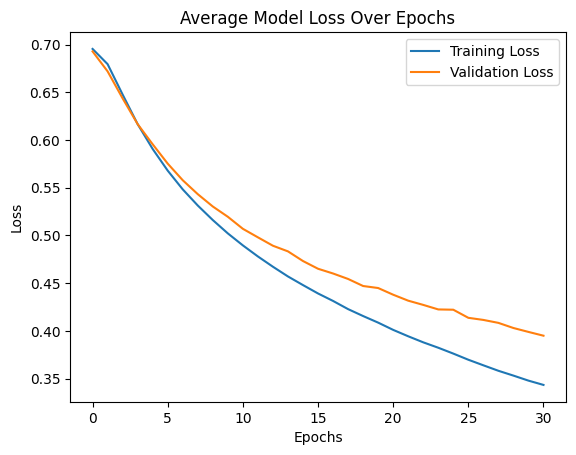

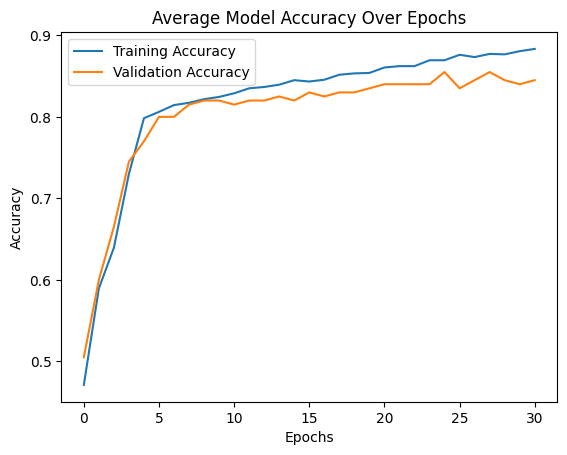

In [208]:
import time
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

kf = KFold(n_splits=10, shuffle=True)

training_times = []
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

vocab_size = len(tokenizer.word_index) + 1

for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{kf.get_n_splits()}")

    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

    # evaluating the model before training
    initial_training_loss, initial_training_accuracy = evaluate_model(X_train_fold, y_train_fold, vocab_size, embedding_matrix)
    initial_validation_loss, initial_validation_accuracy = evaluate_model(X_val_fold, y_val_fold, vocab_size, embedding_matrix)


    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=True))
    model.add(Flatten())
    model.add(Dense(hl1_size, activation=activation, kernel_initializer=initializer, bias_initializer=Initializers.Zeros()))
    # model.add(Dense(2, activation=activation, kernel_initializer=initializer, bias_initializer=Initializers.Zeros()))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=epochs, batch_size=batch_size, verbose=0)
    end_time = time.time()

    training_times.append(end_time - start_time)
    
    train_accuracies.append((initial_training_accuracy, *history.history['accuracy']))
    val_accuracies.append((initial_validation_accuracy, *history.history['val_accuracy']))
    train_losses.append((initial_training_loss, *history.history['loss']))
    val_losses.append((initial_validation_loss, *history.history['val_loss']))
    break # for testing only do one fold

    print(f"Fold {fold + 1}/{kf.get_n_splits()} - Training Time: {training_times[-1]} seconds")
print(f"Average Training Time: {np.mean(training_times)} seconds")

# Convert lists to numpy arrays for easier manipulation
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean values across folds
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

print (mean_train_accuracy)
print (mean_val_accuracy)
print (mean_train_loss)
print (mean_val_loss)

# Plotting
plot_learning_curves('Average Model Loss Over Epochs', mean_train_loss, mean_val_loss, 'Loss')
plot_learning_curves('Average Model Accuracy Over Epochs', mean_train_accuracy, mean_val_accuracy, 'Accuracy')

<h3>fit the model</h3>

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 11ms/step


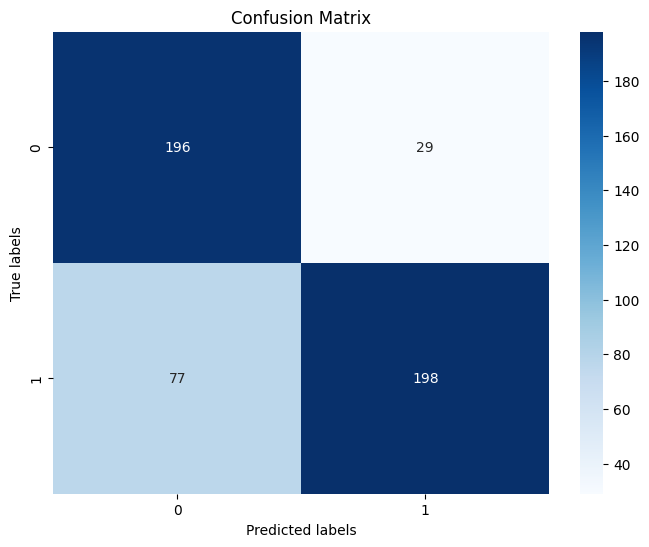

Accuracy: 0.788
Precision: 0.8722466960352423
Recall: 0.72
F1 Score: 0.7888446215139442


In [209]:
embedded_mlp_history = model.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

def evaluate_model_performance(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Evaluate model performance
evaluate_model_performance(y_test, embedded_mlp_history.round())

<h5><u><center>Convolutional Neural Network</center></u></h5>
Below is the implementation of a convolutional neural network model using each record represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.

Model Hyperparameters

In [7]:
# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 64 # Baseline batch size # 32 is best for cnn
epochs = 15 # Baseline number of epochs
learning_rate = 0.0001 # Baseline learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Baseline optimizer
validation_split = 0.1 # Baseline validation split: 10% of the training data
initializer = he_uniform(seed=42) # Baseline initializer
regularizer = l1(0.01) # Baseline regularizer
activation = 'relu' # Baseline activation function - leaky relu, used to prevent dying relu problem as minus numbers and zeros values are a possiblity for some inputs because of dimensional spaces of embedded dimensions
loss = 'binary_crossentropy' # Baseline loss function:binary crossentropy used for binary classification model
hl1_size = 5 # Baseline number of hidden layer neurons


Creating the Model

In [8]:
import tensorflow.keras.initializers as Initializers
from keras.layers import Conv1D, GlobalMaxPooling1D

def evaluate_model(X, y, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
    # 64 filters
    model.add(Conv1D(16, 5, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)) # 128 by default trying 64 instead to combat overfitting
    model.add(GlobalMaxPooling1D())
    model.add(Dense(4, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(X, y)

    return loss, accuracy

In [12]:
from keras.layers import Conv1D, GlobalMaxPooling1D



cnn = Sequential()
cnn.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
# 64 filters
cnn.add(Conv1D(64, 5, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)) # 128 by default trying 64 instead to combat overfitting
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(4, activation=activation))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(X_train, y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=2)


Epoch 1/15
29/29 - 6s - loss: 20.2074 - acc: 0.5978 - val_loss: 10.2077 - val_acc: 0.6150 - 6s/epoch - 194ms/step
Epoch 2/15
29/29 - 4s - loss: 5.1765 - acc: 0.7167 - val_loss: 1.6723 - val_acc: 0.7200 - 4s/epoch - 141ms/step
Epoch 3/15
29/29 - 4s - loss: 1.2124 - acc: 0.6956 - val_loss: 0.9381 - val_acc: 0.7000 - 4s/epoch - 136ms/step
Epoch 4/15
29/29 - 4s - loss: 0.8607 - acc: 0.7106 - val_loss: 0.8391 - val_acc: 0.6800 - 4s/epoch - 136ms/step
Epoch 5/15
29/29 - 4s - loss: 0.8069 - acc: 0.7111 - val_loss: 0.8224 - val_acc: 0.7050 - 4s/epoch - 142ms/step
Epoch 6/15
29/29 - 4s - loss: 0.7875 - acc: 0.7394 - val_loss: 0.8132 - val_acc: 0.7250 - 4s/epoch - 144ms/step
Epoch 7/15
29/29 - 4s - loss: 0.7802 - acc: 0.7717 - val_loss: 0.8027 - val_acc: 0.7450 - 4s/epoch - 147ms/step
Epoch 8/15
29/29 - 4s - loss: 0.7449 - acc: 0.8056 - val_loss: 0.7882 - val_acc: 0.8000 - 4s/epoch - 149ms/step
Epoch 9/15
29/29 - 4s - loss: 0.7355 - acc: 0.8456 - val_loss: 0.7738 - val_acc: 0.8150 - 4s/epoch - 1

In [13]:
# Print csv stats
val_loss = history.history['val_loss']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
train_accuracy = history.history['acc']

print (val_loss)
print (val_accuracy)
print (train_loss)
print (train_accuracy)

[10.207683563232422, 1.6723296642303467, 0.938088059425354, 0.839148998260498, 0.8223928809165955, 0.8132334351539612, 0.80266934633255, 0.7882093191146851, 0.7737510800361633, 0.7695813179016113, 0.7340918183326721, 0.7158220410346985, 0.6931103467941284, 0.6821441650390625, 0.6527641415596008]
[0.6150000095367432, 0.7200000286102295, 0.699999988079071, 0.6800000071525574, 0.7049999833106995, 0.7250000238418579, 0.7450000047683716, 0.800000011920929, 0.8149999976158142, 0.8349999785423279, 0.8550000190734863, 0.8500000238418579, 0.8600000143051147, 0.8550000190734863, 0.875]
[20.20740509033203, 5.176521301269531, 1.2124406099319458, 0.8607189059257507, 0.806852400302887, 0.7874743938446045, 0.78019118309021, 0.7449313402175903, 0.7354660630226135, 0.688129723072052, 0.6747758388519287, 0.6276800036430359, 0.6151983737945557, 0.5529022812843323, 0.532475471496582]
[0.597777783870697, 0.7166666388511658, 0.695555567741394, 0.7105555534362793, 0.7111111283302307, 0.7394444346427917, 0.77

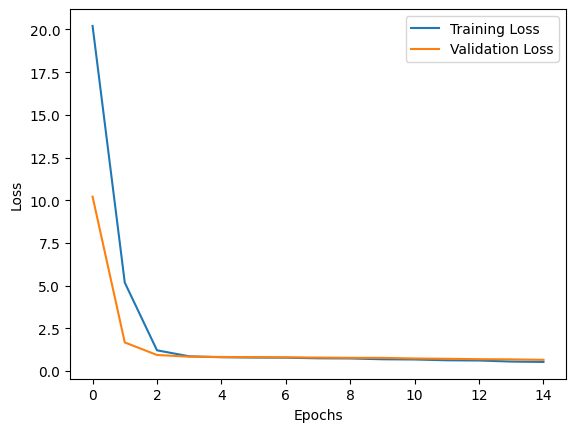

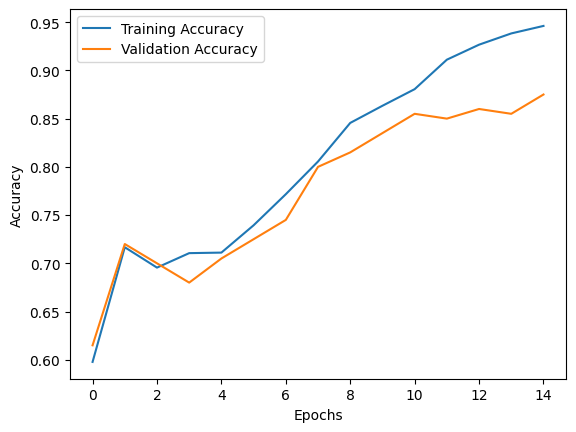

In [15]:
# Plot training and validation loss
plot_learning_curves('CNN Learning Curve Loss', train_loss, val_loss, 'Loss')

# Plot training and validation accuracy
plot_learning_curves('CNN Learning Curve Accuracy', train_accuracy, val_accuracy, 'Accuracy')

16/16 [==============================] - 0s 10ms/step


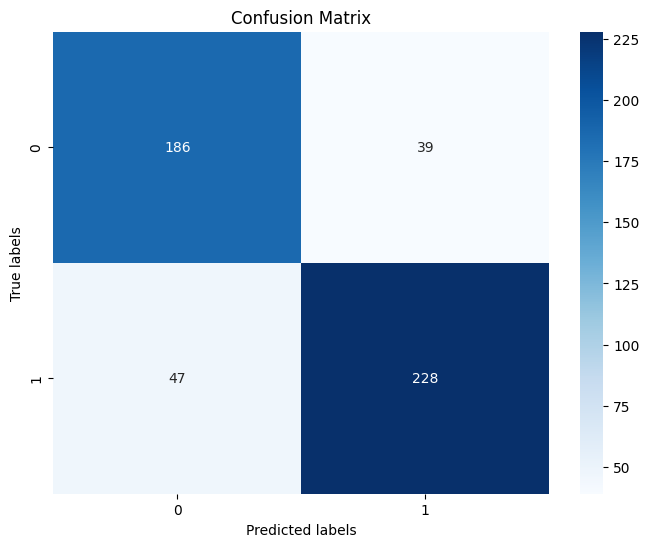

Accuracy: 0.828
Precision: 0.8539325842696629
Recall: 0.8290909090909091
F1 Score: 0.8413284132841329


In [240]:
embedded_mlp_history = cnn.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

def evaluate_model_performance(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Evaluate model performance
evaluate_model_performance(y_test, embedded_mlp_history.round())

<h5><center>Recurrent Neural Network (RNN)</center></h5>
<h5>
In this approach I utilizie a Recurrent Neural Netowr model where each record is represented as a sequence of pre-train word embedding vectors, using the Keras Embedding layer.
</h5>

In [111]:
from keras.layers import LSTM, Dense, Embedding

model = Sequential()
model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
model.add(LSTM(68)) # was 128 before
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32, verbose=2)


Epoch 1/10
57/57 - 51s - loss: 0.4151 - acc: 0.7994 - val_loss: 0.2590 - val_acc: 0.8950 - 51s/epoch - 889ms/step
Epoch 2/10
57/57 - 52s - loss: 0.2067 - acc: 0.9250 - val_loss: 0.2365 - val_acc: 0.9000 - 52s/epoch - 917ms/step
Epoch 3/10
57/57 - 52s - loss: 0.0970 - acc: 0.9706 - val_loss: 0.2665 - val_acc: 0.8750 - 52s/epoch - 913ms/step
Epoch 4/10
57/57 - 52s - loss: 0.0346 - acc: 0.9883 - val_loss: 0.3318 - val_acc: 0.8850 - 52s/epoch - 919ms/step
Epoch 5/10
57/57 - 55s - loss: 0.0161 - acc: 0.9967 - val_loss: 0.2907 - val_acc: 0.8850 - 55s/epoch - 958ms/step
Epoch 6/10


KeyboardInterrupt: 

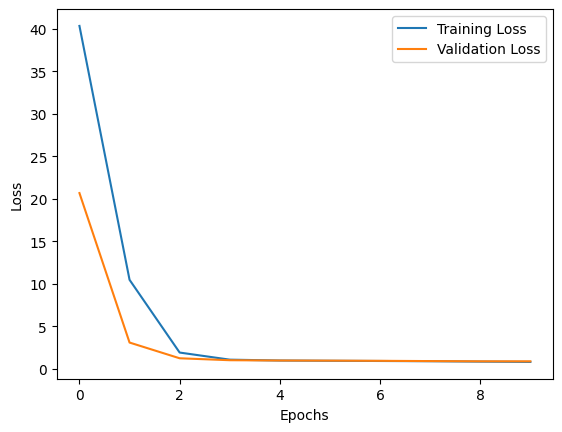

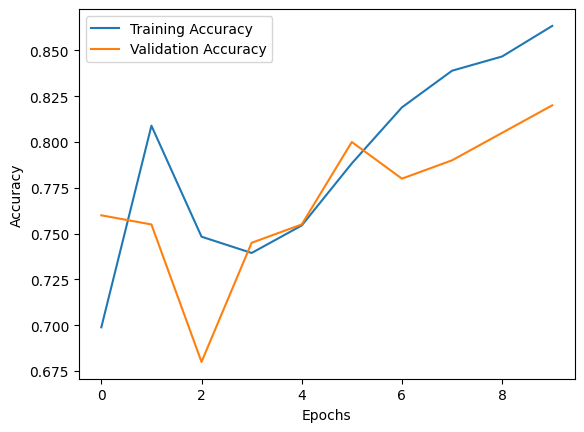

In [32]:
# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
train_accuracy = history.history['acc']

# Plot training and validation loss
plot_learning_curves('RNN Learning Curve Loss', train_loss, val_loss, 'Loss')
# Plot training and validation accuracy
plot_learning_curves('RNN Learning Curve Accuracy', train_accuracy, val_accuracy, 'Accuracy')

In [31]:
embedded_mlp_history = model_2.predict(X_test)

def evaluate_model_performance(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Evaluate model performance
evaluate_model_performance(y_test, embedded_mlp_history.round())

NameError: name 'model_2' is not defined